In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
holidayEvents=pd.read_csv ('holidays_events.csv')
oil=pd.read_csv('oil.csv')
stores=pd.read_csv('stores.csv')
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')
transactions=pd.read_csv('transactions.csv')

In [4]:
train1 = train.merge(oil, on = 'date', how='left')
train1 = train1.merge(holidayEvents, on = 'date', how='left')
train1 = train1.merge(stores, on = 'store_nbr', how='left')
train1 = train1.merge(transactions, on = ['date', 'store_nbr'], how='left')
train1 = train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

In [5]:
train1['date'] = pd.to_datetime(train1['date'])
train1['year'] = train1['date'].dt.year
train1['month'] = train1['date'].dt.month
train1['week'] = train1['date'].dt.isocalendar().week
train1['quarter'] = train1['date'].dt.quarter
train1['day_of_week'] = train1['date'].dt.day_name()

In [6]:
train1.head(10)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,...,city,state,store_type,cluster,transactions,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
6,6,2013-01-01,1,CELEBRATION,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
7,7,2013-01-01,1,CLEANING,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
8,8,2013-01-01,1,DAIRY,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday
9,9,2013-01-01,1,DELI,0.0,0,NaN,Holiday,National,Ecuador,...,Quito,Pichincha,D,13,NaN,2013,1,1,1,Tuesday


In [7]:
df = train1[['date', 'sales']]

In [8]:
df=df.set_index(df.date)
df.drop('date',axis=1,inplace=True)

In [9]:
df.tail

<bound method NDFrame.tail of                sales
date                
2013-01-01     0.000
2013-01-01     0.000
2013-01-01     0.000
2013-01-01     0.000
2013-01-01     0.000
...              ...
2017-08-15   438.133
2017-08-15   154.553
2017-08-15  2419.729
2017-08-15   121.000
2017-08-15    16.000

[3054348 rows x 1 columns]>

In [10]:
#resample it to monthly basis to make analysis easier
df = df.resample('M').mean()

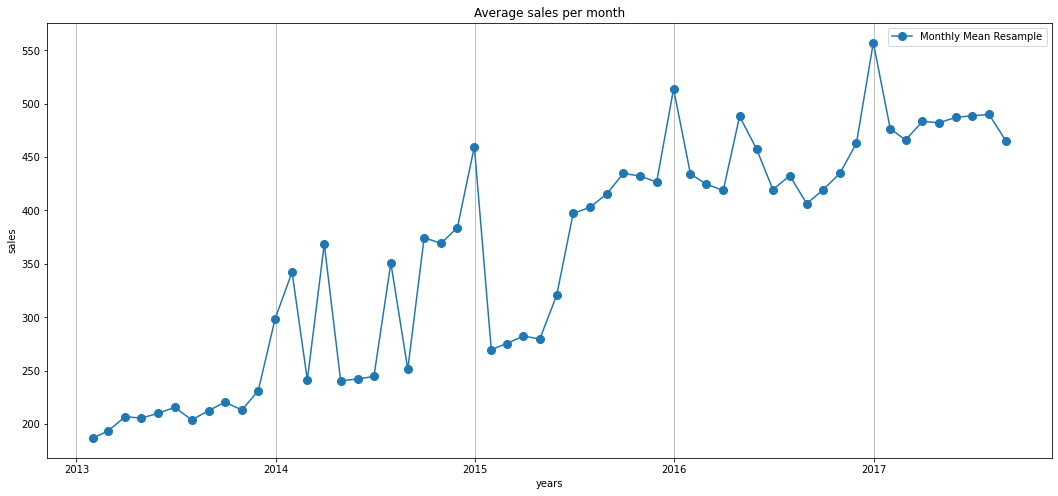

In [11]:
y = df['sales']
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend();

Increasing Trend in Average Sales

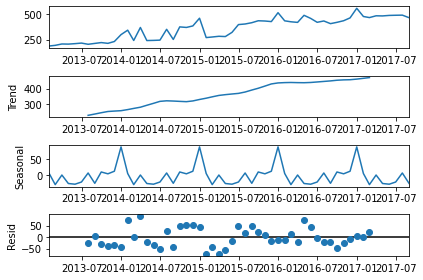

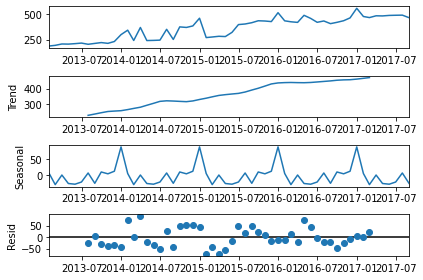

In [12]:
df_decomposed = seasonal_decompose(df,model='additive')
df_decomposed.plot()

Seasonality is also absorved throughout in addition to increasing trend

### Stationarity Check : Augmented Dickey-Fuller test (ADF test)

H0 : 'The time series is not stationary' \
H1 : 'The time series is stationary'

In [13]:
dftest = adfuller(df.dropna(), autolag='AIC')

In [14]:
print("test statistic:",dftest[0],"\n P-value:" ,dftest[1],"\nCritiical Values",dftest[4])

test statistic: -1.581928187307198 
 P-value: 0.492664903858226 
Critiical Values {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


With 99%, 95% and 90% data is not stationary, so need to make it stationary

Visualizing Stationarity

In [15]:
sales_mean = df.sales.rolling(window=12).mean()
sales_std = df.sales.rolling(window=12).std()

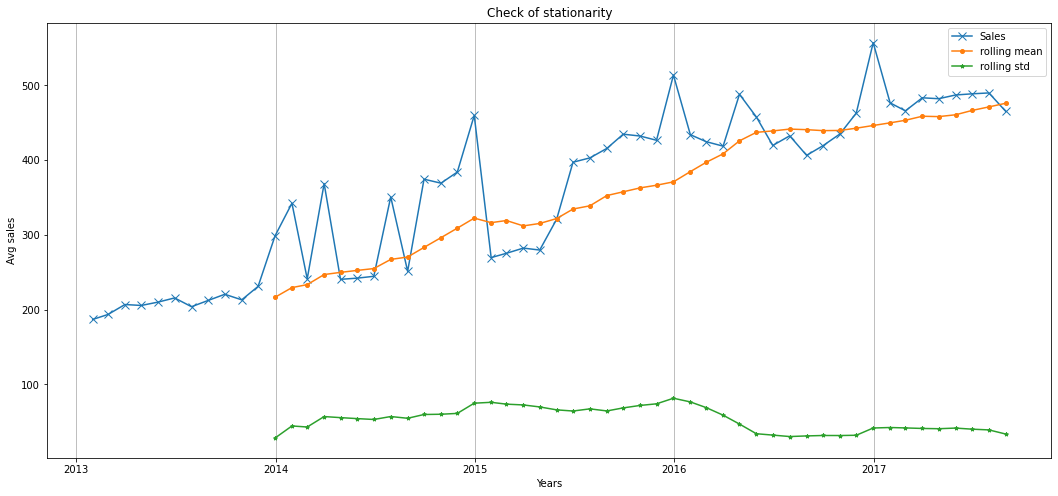

In [16]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df.sales,marker='x', markersize=8, label='Sales')
ax.plot(sales_mean,marker='o', markersize=4, label='rolling mean');
ax.plot(sales_std,marker='*', markersize=4, label='rolling std');
ax.legend()
plt.xlabel('Years')
plt.ylabel('Avg sales')
plt.title('Check of stationarity')
ax.grid(axis='x')

Hypothesis testing coincides with visualization, the data is not stationary although SD seems a bit constant

Inducing Lag to make data stationary

In [17]:
df_lag = df.sales - df.sales.shift(12) #monthly lag

In [18]:
df_lag.tail(10)

date
2016-11-30    36.336926
2016-12-31    43.269494
2017-01-31    42.546523
2017-02-28    41.276070
2017-03-31    64.665233
2017-04-30    -5.935826
2017-05-31    29.491399
2017-06-30    69.062703
2017-07-31    57.347661
2017-08-31    58.707501
Freq: M, Name: sales, dtype: float64

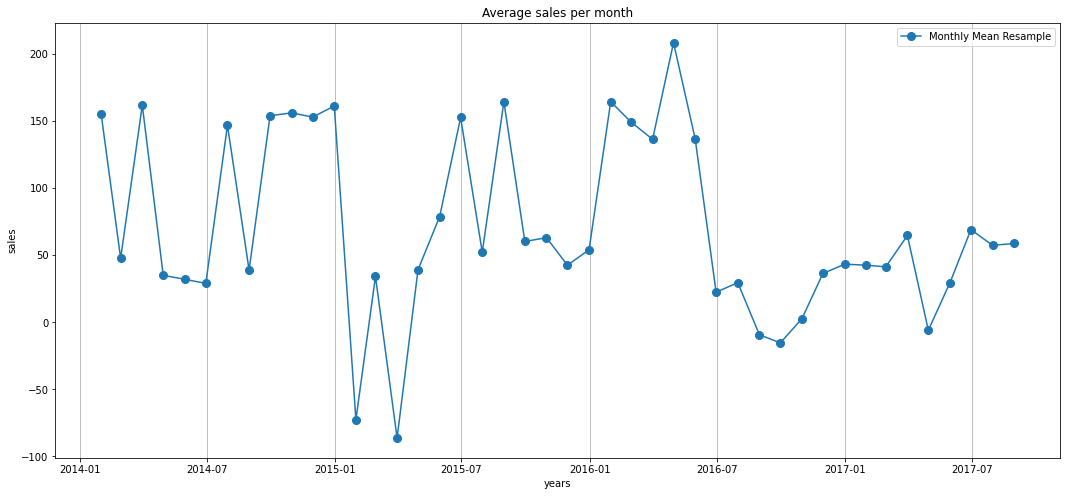

In [19]:
y = df_lag
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend();

In [20]:
dftest = adfuller(df_lag.dropna(), autolag='AIC')

In [21]:
print("test statistic:",dftest[0],"\n P-value:" ,dftest[1],"\nCritiical Values",dftest[4])

test statistic: -3.7341645625933024 
 P-value: 0.003657471301306856 
Critiical Values {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}


With 99%,95%,90% confidence the data is stationary

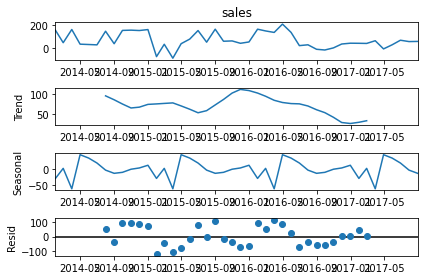

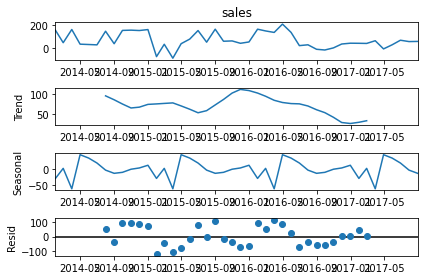

In [22]:
df_decomposed = seasonal_decompose(df_lag.dropna(),model='additive')
df_decomposed.plot()